In [41]:
"""Remap both action spaces: vasopressor and intravous fluid.

NOTE: Change 'timestep'.
"""
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [42]:
timestep = 8

read_dir = rf'F:\time_step\OfflineRL_FactoredActions\RL_mimic_sepsis\data\data_asNormThreshold_dt{timestep}h'
save_dir = read_dir

df_raw = pd.read_csv(os.path.join(read_dir, f'sepsis_final_data_RAW_withTimes_dt{timestep}h.csv'))

# Try to read filled version, if failed read original version, typically for 4h and 8h.
try: 
    df_data = pd.read_csv(os.path.join(read_dir, f'sepsis_final_data_FILLED_withTimes_dt{timestep}h.csv'))
except FileNotFoundError:
    df_data = pd.read_csv(os.path.join(read_dir, f'sepsis_final_data_withTimes_dt{timestep}h.csv'))

In [43]:
df_raw.head()

,traj,step,m:presumed_onset,m:charttime,m:icustayid,o:gender,o:mechvent,o:max_dose_vaso,o:re_admission,o:age,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:input_4hourly,o:output_total,o:output_4hourly,a:action,r:reward
0,1,0,7.245590e+09,7.245486e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.7,6567.0,90.0,13922.0,825.0,10,0.0
1,1,1,7.245590e+09,7.245515e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.3,6657.0,90.0,14492.0,570.0,10,0.0
2,1,2,7.245590e+09,7.245544e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.2,6717.0,60.0,15252.0,760.0,5,0.0
3,1,3,7.245590e+09,7.245601e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,34.0,30.0,4.3,1.1,6717.0,0.0,15252.0,0.0,0,1.0
4,2,0,6.898284e+09,6.898241e+09,200011.0,1.0,1.0,0.0,1.0,30766.069028,...,26.0,20.0,0.4,0.9,0.0,0.0,460.0,460.0,0,0.0


In [44]:
interventions = df_raw[['o:max_dose_vaso', 'o:input_4hourly']].copy()

In [45]:
# Only compute quartiles on nonzero values.
adjusted_vaso = interventions["o:max_dose_vaso"][interventions["o:max_dose_vaso"] > 0]
adjusted_iv = interventions["o:input_4hourly"][interventions["o:input_4hourly"] > 0]

In [46]:
vaso_quartiles = adjusted_vaso.quantile([0.25, 0.50, 0.75])
iv_quartiles = adjusted_iv.quantile([0.25, 0.5, 0.75])

In [ ]:
vpq = np.array(vaso_quartiles)
ivq = np.array(iv_quartiles)

print('Old IV fluids bins:', ivq)
print('Old Vasopressor bins:', vpq)

Old Vasopressor bins: [0.08 0.2  0.45]
Old IV fluids bins: [ 90.   321.25 900.  ]


In [48]:
# Normalize i.v. by timestep.
newivq  = np.array([500, 1000, 2000]) * (timestep / 4) 
newvpq  = np.array([0.08, 0.2, 0.45])
print('New IV fluids bins:', newivq)
print('New Vasopressor bins:', newvpq)

New IV fluids bins: [1000. 2000. 4000.]
New Vasopressor bins: [0.08 0.2  0.45]


In [ ]:
'''Calculate old actions.'''

def mimic_bin(series, input_type):
    """Change the old binning method into the same one as mimic-sepsis code."""
    arr = series.to_numpy()
    bin_ = np.ones(len(arr), dtype=int)          
    mask = arr > 0
    ranks = stats.rankdata(arr[mask]) / mask.sum()
    if input_type == 'iv':
        bin_[mask] = np.floor((ranks + 0.2499999999) * 4).astype(int) + 1
    elif input_type == 'vaso':
        bin_[mask] = np.floor((ranks + 0.249999999999) * 4).astype(int) + 1 
    return bin_ - 1   

interventions['a:iv_OLD']   = mimic_bin(interventions['o:input_4hourly'], 'iv')
interventions['a:vaso_OLD'] = mimic_bin(interventions['o:max_dose_vaso'], 'vaso')

In [50]:
interventions['a:vaso'] = np.array(0, dtype=int)
interventions.loc[(interventions['o:max_dose_vaso'] == 0.0   ), 'a:vaso'] = 0

interventions.loc[(interventions['o:max_dose_vaso'] >  0.0   ) 
                  & (interventions['o:max_dose_vaso'] < newvpq[0]), 'a:vaso'] = 1

interventions.loc[(interventions['o:max_dose_vaso'] >= newvpq[0]) 
                  & (interventions['o:max_dose_vaso'] < newvpq[1]), 'a:vaso'] = 2

interventions.loc[(interventions['o:max_dose_vaso'] >= newvpq[1]) 
                  & (interventions['o:max_dose_vaso'] < newvpq[2]), 'a:vaso'] = 3

interventions.loc[(interventions['o:max_dose_vaso'] >= newvpq[2]), 'a:vaso'] = 4

In [51]:
interventions['a:iv'] = np.array(0, dtype=int)
interventions.loc[(interventions['o:input_4hourly'] == 0.0), 'a:iv'] = 0

interventions.loc[(interventions['o:input_4hourly'] >  0.0) 
                  & (interventions['o:input_4hourly'] < newivq[0]), 'a:iv'] = 1

interventions.loc[(interventions['o:input_4hourly'] >= newivq[0]) 
                  & (interventions['o:input_4hourly'] < newivq[1]), 'a:iv'] = 2

interventions.loc[(interventions['o:input_4hourly'] >= newivq[1]) 
                  & (interventions['o:input_4hourly'] < newivq[2]), 'a:iv'] = 3

interventions.loc[(interventions['o:input_4hourly'] >= newivq[2]), 'a:iv'] = 4

In [52]:
interventions['a:action_OLD'] = interventions['a:iv_OLD'] * 5 + interventions['a:vaso_OLD']
interventions['a:action'] = interventions['a:iv'] * 5 + interventions['a:vaso']

In [53]:
interventions

,o:max_dose_vaso,o:input_4hourly,a:iv_OLD,a:vaso_OLD,a:vaso,a:iv,a:action_OLD,a:action
0,0.0,90.0,2,0,0,1,10,5
1,0.0,90.0,2,0,0,1,10,5
2,0.0,60.0,1,0,0,1,5,5
3,0.0,0.0,0,0,0,0,0,0
4,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
132033,0.0,80.0,1,0,0,1,5,5
132034,0.0,0.0,0,0,0,0,0,0
132035,0.0,0.0,0,0,0,0,0,0
132036,0.0,0.0,0,0,0,0,0,0


In [54]:
(interventions['a:action_OLD'] == df_raw['a:action']).mean()

1.0

In [55]:
newdf_raw = pd.concat([df_raw.drop(columns=['a:action', 'o:max_dose_vaso', 'o:input_4hourly']), interventions], axis=1)
newdf_data = pd.concat([df_data.drop(columns=['a:action', 'o:max_dose_vaso', 'o:input_4hourly']), interventions], axis=1)

In [56]:
newdf_raw.to_csv(os.path.join(save_dir, f'sepsis_final_data_RAW_withTimes_dt{timestep}h_asNormThreshold.csv'), index=False)
newdf_data.to_csv(os.path.join(save_dir, f'sepsis_final_data_FILLED_withTimes_dt{timestep}h_asNormThreshold.csv'), index=False)

### Visualize

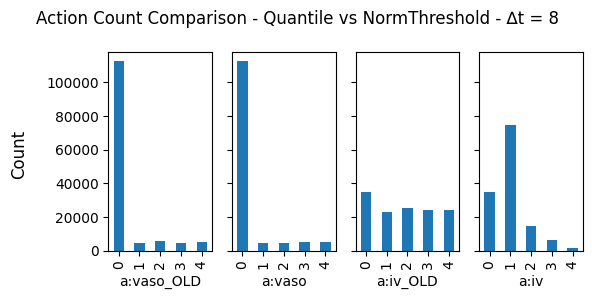

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(6,3), sharey=True)
interventions['a:vaso_OLD'].value_counts().loc[[0,1,2,3,4]].plot(kind='bar', ax=axes[0], xlabel='a:vaso_OLD')
interventions['a:vaso'].value_counts().loc[[0,1,2,3,4]].plot(kind='bar', ax=axes[1], xlabel='a:vaso')
interventions['a:iv_OLD'].value_counts().loc[[0,1,2,3,4]].plot(kind='bar', ax=axes[2], xlabel='a:iv_OLD')
interventions['a:iv'].value_counts().loc[[0,1,2,3,4]].plot(kind='bar', ax=axes[3], xlabel='a:iv')
fig.supylabel('Count')
plt.suptitle(f'Action Count Comparison - Quantile vs NormThreshold - ∆t = {timestep}')
plt.tight_layout()
plt.savefig((r'F:\time_step\OfflineRL_FactoredActions\RL_mimic_sepsis\a_cohort\figs'
             rf'\figs_asNormThreshold_dt{timestep}h/countcompare.png'), dpi=600, bbox_inches='tight')
plt.show()

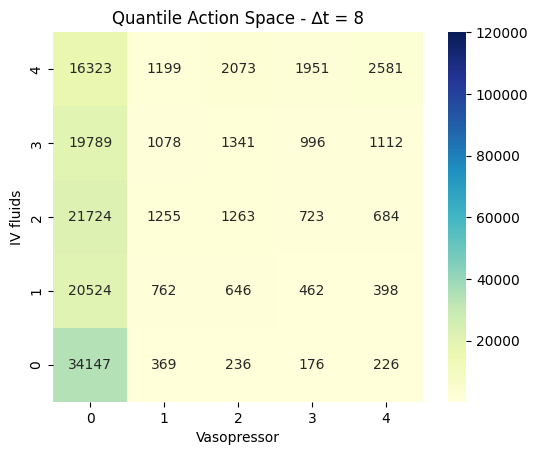

In [58]:
fig, ax = plt.subplots()
sns.heatmap(interventions['a:action_OLD'].value_counts().sort_index().to_numpy().reshape((5,5)),
            ax=ax, square=True, cmap="YlGnBu", vmax=1.2e5, annot=True, fmt='d')
ax.invert_yaxis()
plt.title(f'Quantile Action Space - ∆t = {timestep}')
plt.xlabel('Vasopressor')
plt.ylabel('IV fluids')
plt.savefig((r'F:\time_step\OfflineRL_FactoredActions\RL_mimic_sepsis\a_cohort\figs'
             rf'\figs_asNormThreshold_dt{timestep}h/quantile_action_space.png'), dpi=600, bbox_inches='tight')
plt.show()

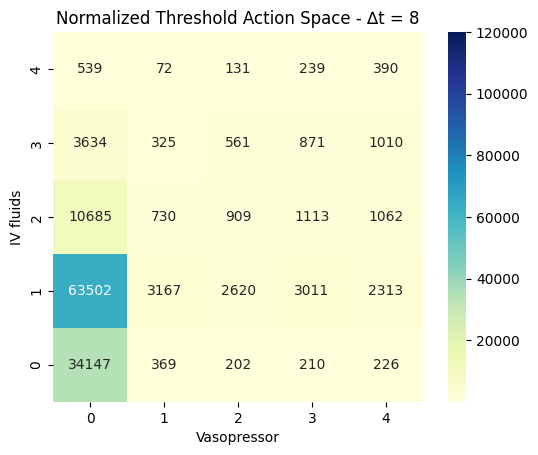

In [59]:
fig, ax = plt.subplots()
sns.heatmap(interventions['a:action'].value_counts().sort_index().to_numpy().reshape((5,5)),
            ax=ax, square=True, cmap="YlGnBu", vmax=1.2e5, annot=True, fmt='d')
ax.invert_yaxis()
plt.title(f'Normalized Threshold Action Space - ∆t = {timestep}')
plt.xlabel('Vasopressor')
plt.ylabel('IV fluids')
plt.savefig((r'F:\time_step\OfflineRL_FactoredActions\RL_mimic_sepsis\a_cohort\figs'
             rf'\figs_asNormThreshold_dt{timestep}h/NormThreshold_action_space.png'), dpi=600, bbox_inches='tight')
plt.show()